In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp

In [2]:
import faraway.datasets.prostate
prostate = faraway.datasets.prostate.load()
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579819,2.7695,50,-1.386294,0,-1.38629,6,0,-0.43078
1,-0.994252,3.3196,58,-1.386294,0,-1.38629,6,0,-0.16252
2,-0.510826,2.6912,74,-1.386294,0,-1.38629,7,20,-0.16252
3,-1.203973,3.2828,58,-1.386294,0,-1.38629,6,0,-0.16252
4,0.751416,3.4324,62,-1.386294,0,-1.38629,6,0,0.37156


In [3]:
%run utils.ipynb

In [4]:
print(
faraway.datasets.prostate.DESCR
)


Prostate cancer surgery

Description:

     The ‘prostate’ data frame has 97 rows and 9 columns. A study on 97
     men with prostate cancer who were due to receive a radical
     prostatectomy.

Variables:

     This data frame contains the following columns:

     ‘lcavol’ log(cancer volume)

     ‘lweight’ log(prostate weight)

     ‘age’ age

     ‘lbph’ log(benign prostatic hyperplasia amount)

     ‘svi’ seminal vesicle invasion

     ‘lcp’ log(capsular penetration)

     ‘gleason’ Gleason score

     ‘pgg45’ percentage Gleason scores 4 or 5

     ‘lpsa’ log(prostate specific antigen)

Source:

     Andrews DF and Herzberg AM (1985): Data. New York: Springer-Verlag



In [5]:
import faraway.utils

lmod = smf.ols(
    "lpsa ~ lcavol + lweight + age + lbph + svi + lcp + gleason + pgg45",
    data=prostate
).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept  0.669  1.296    0.52  0.6069
lcavol     0.587  0.088    6.68  0.0000
lweight    0.454  0.170    2.67  0.0090
age       -0.020  0.011   -1.76  0.0823
lbph       0.107  0.058    1.83  0.0704
svi        0.766  0.244    3.14  0.0023
lcp       -0.105  0.091   -1.16  0.2496
gleason    0.045  0.157    0.29  0.7750
pgg45      0.005  0.004    1.02  0.3089

n=97 p=9 Residual SD=0.708 R-squared=0.65


(<Figure size 1440x504 with 2 Axes>,
 array([<AxesSubplot:xlabel='y.hat', ylabel='e.hat'>,
        <AxesSubplot:xlabel='y.hat', ylabel='sqrt(|e.hat|)'>], dtype=object))

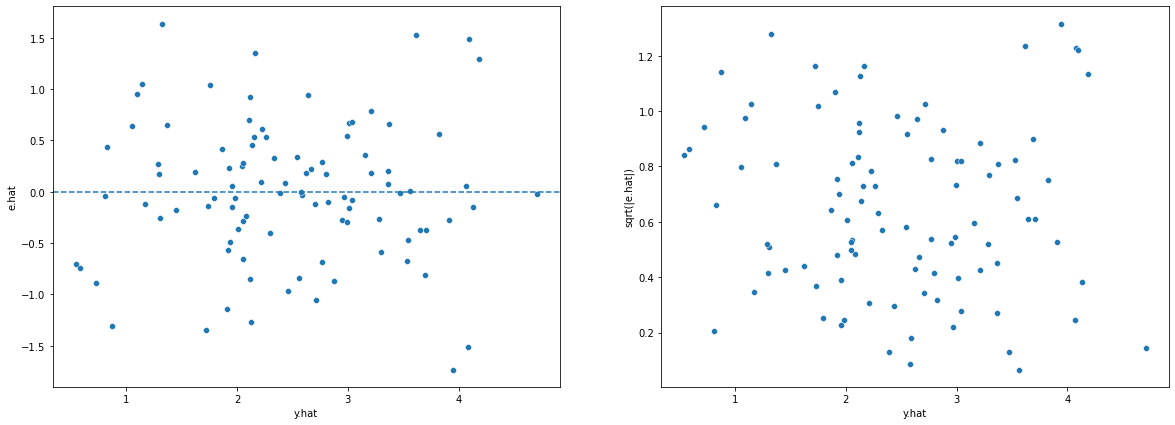

In [6]:
resid_yhat_plot(lmod)

Looks perfectly normal to me.

In [7]:
diagv = lmod.get_influence()
n =  prostate.shape[0]
lev = diagv.hat_matrix_diag
threshold = 2 * (n - lmod.df_resid) / n
high_lev = pd.Series(lev[lev > threshold])
high_lev

0    0.330476
1    0.218439
2    0.241008
3    0.191211
4    0.209242
dtype: float64

In [8]:
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept  0.669  1.296    0.52  0.6069
lcavol     0.587  0.088    6.68  0.0000
lweight    0.454  0.170    2.67  0.0090
age       -0.020  0.011   -1.76  0.0823
lbph       0.107  0.058    1.83  0.0704
svi        0.766  0.244    3.14  0.0023
lcp       -0.105  0.091   -1.16  0.2496
gleason    0.045  0.157    0.29  0.7750
pgg45      0.005  0.004    1.02  0.3089

n=97 p=9 Residual SD=0.708 R-squared=0.65


Non-significant: $age, lbph, lcp, gleason, pgg45$

### I cut the model to see its effect on the diagnostics: (?)

In [9]:
lmod_cut = smf.ols(
    "lpsa ~ lcavol + lweight + svi",
    data=prostate
).fit()
lmod_cut.sumary()

           coefs stderr tvalues pvalues
Intercept -0.268  0.543   -0.49  0.6230
lcavol     0.552  0.075    7.39  0.0000
lweight    0.509  0.150    3.39  0.0010
svi        0.666  0.210    3.18  0.0020

n=97 p=4 Residual SD=0.717 R-squared=0.63


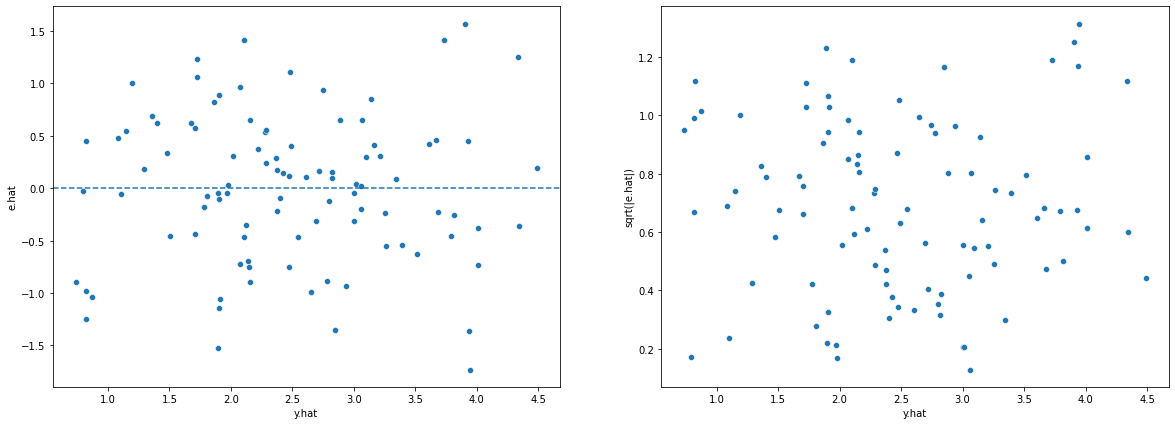

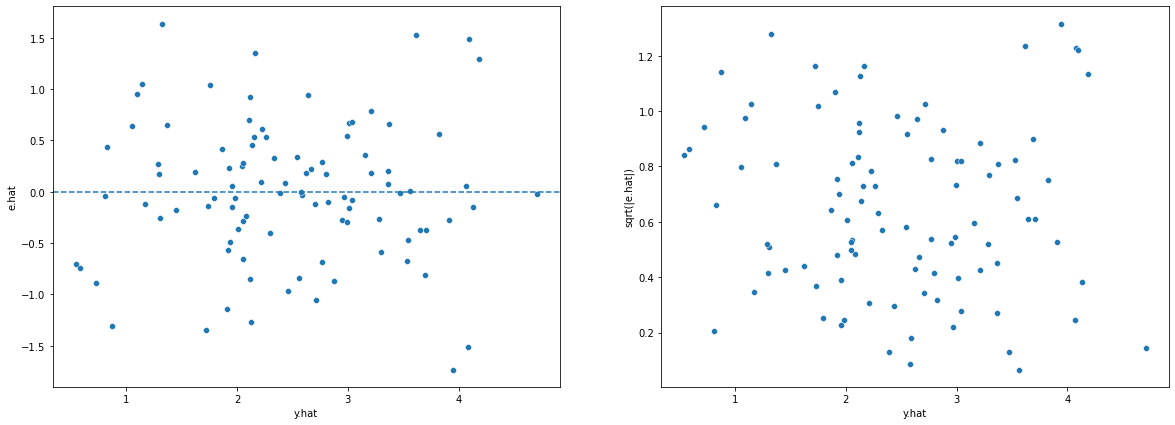

In [10]:
_ = resid_yhat_plot(lmod_cut)
_ = resid_yhat_plot(lmod)

The plots are identical

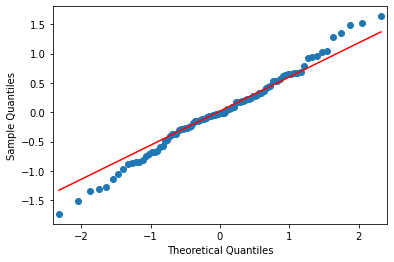

In [11]:
_ = sm.qqplot(lmod.resid, line="q")

In [12]:
sp.stats.shapiro(lmod.resid)

ShapiroResult(statistic=0.9911287426948547, pvalue=0.7721095085144043)

In [13]:
sm.stats.stattools.durbin_watson(lmod.resid)

1.5069645441158106

In [14]:
diagv_cut = lmod_cut.get_influence()
lev_cut = pd.Series(diagv_cut.hat_matrix_diag)
high_lev_cut = lev_cut[lev_cut > threshold]
print(high_lev_cut)
lev_cut.sort_values(ascending=False).head()

31    0.306014
dtype: float64


31    0.306014
88    0.087305
37    0.080146
11    0.073446
68    0.071509
dtype: float64

Text(0.5, 1.0, 'New leverages')

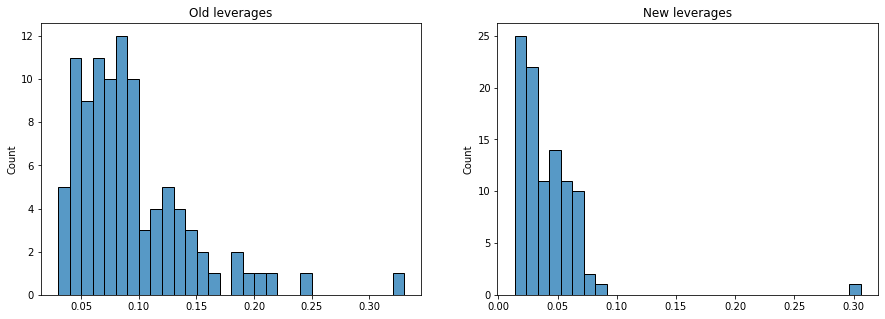

In [15]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(lev, bins=30, ax=ax[0])
ax[0].set_title("Old leverages")
sns.histplot(lev_cut, bins=30, ax=ax[1])
ax[1].set_title("New leverages")

In [16]:
unusual_record = prostate.loc[31, :]
unusual_record_standard = unusual_record.copy()

logged_cols = ['lcavol', 'lweight', 'lbph', 'lweight', 'lcp', 'lpsa']
unusual_record_standard.drop(index=logged_cols, inplace=True)

for col in logged_cols:
    stand_col = col[1:]
    unusual_record_standard[stand_col] = np.exp(unusual_record.loc[col])
    
unusual_record_standard

age         65.000000
svi          0.000000
gleason      6.000000
pgg45        0.000000
cavol        1.200000
weight     449.259198
bph          5.499999
cp           0.250001
psa          7.449970
Name: 31, dtype: float64

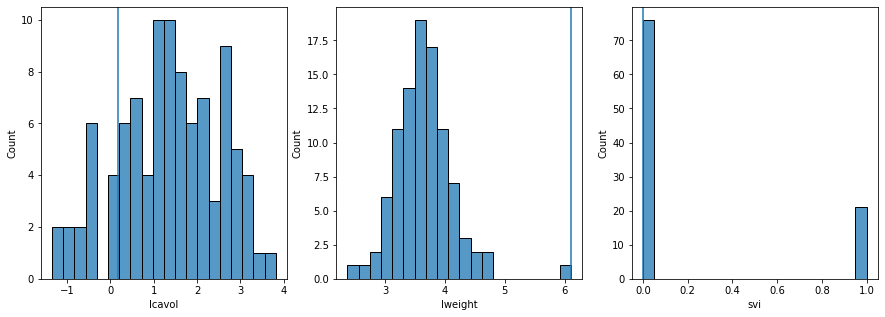

In [17]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, predictor in enumerate(['lcavol', 'lweight', 'svi']):
    sns.histplot(x=predictor, data=prostate, bins=20, ax=ax[i])
    ax[i].axvline(unusual_record.loc[predictor])


In [18]:
np.exp(prostate['lweight']).describe()

count     97.000000
mean      45.477973
std       45.610845
min       10.749938
25%       29.250597
50%       37.449749
75%       48.351633
max      449.259198
Name: lweight, dtype: float64

In [19]:
lmod_cut2 = smf.ols(
    "lpsa ~ lcavol + lweight + svi",
    data=prostate.drop(31)
).fit()

lmod_cut.sumary()
lmod_cut2.sumary()

           coefs stderr tvalues pvalues
Intercept -0.268  0.543   -0.49  0.6230
lcavol     0.552  0.075    7.39  0.0000
lweight    0.509  0.150    3.39  0.0010
svi        0.666  0.210    3.18  0.0020

n=97 p=4 Residual SD=0.717 R-squared=0.63
           coefs stderr tvalues pvalues
Intercept -0.770  0.627   -1.23  0.2225
lcavol     0.528  0.076    6.98  0.0000
lweight    0.659  0.177    3.72  0.0003
svi        0.666  0.208    3.20  0.0019

n=96 p=4 Residual SD=0.711 R-squared=0.64


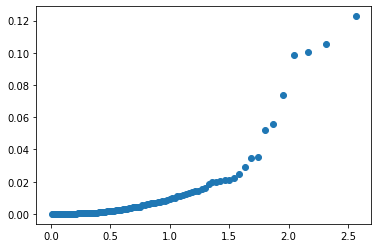

In [20]:
cooks = pd.Series(diagv.cooks_distance[0])
_ = halfqq_plot(cooks)

In [21]:
high_cooks = cooks.sort_values(ascending=False)[:7]
high_cooks

31    0.122698
46    0.105744
68    0.100538
94    0.098738
96    0.073776
95    0.055939
38    0.052019
dtype: float64

In [22]:
high = pd.concat([high_cooks, high_lev]) 
high

31    0.122698
46    0.105744
68    0.100538
94    0.098738
96    0.073776
95    0.055939
38    0.052019
0     0.330476
1     0.218439
2     0.241008
3     0.191211
4     0.209242
dtype: float64

(<Figure size 1440x504 with 2 Axes>,
 array([<AxesSubplot:xlabel='y.hat', ylabel='e.hat'>,
        <AxesSubplot:xlabel='y.hat', ylabel='sqrt(|e.hat|)'>], dtype=object))

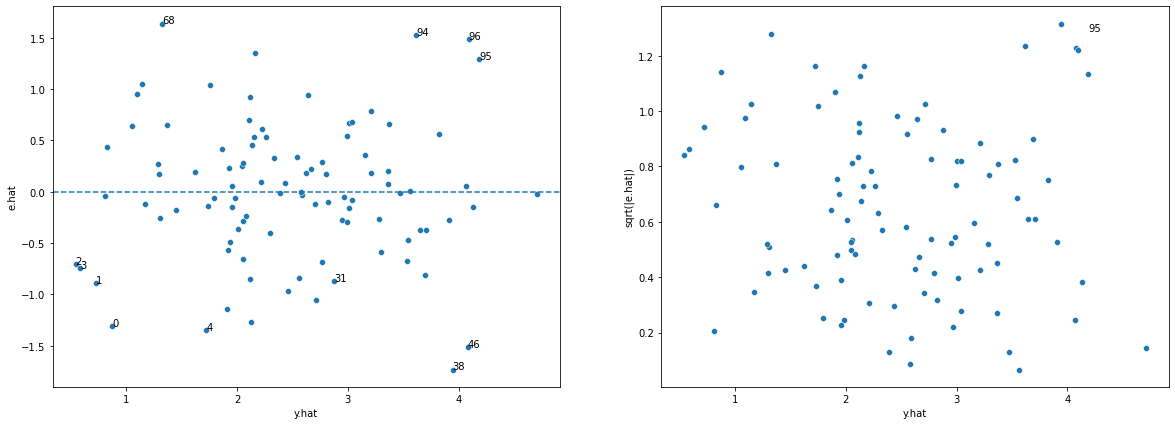

In [23]:
resid_yhat_plot(lmod, to_annotate=high.index)

In [24]:
lmod_cut3 = smf.ols(
    "lpsa ~ lcavol + lweight + svi",
    data=prostate.drop(high.index)
).fit()

lmod_cut.sumary()
lmod_cut3.sumary()

           coefs stderr tvalues pvalues
Intercept -0.268  0.543   -0.49  0.6230
lcavol     0.552  0.075    7.39  0.0000
lweight    0.509  0.150    3.39  0.0010
svi        0.666  0.210    3.18  0.0020

n=97 p=4 Residual SD=0.717 R-squared=0.63
           coefs stderr tvalues pvalues
Intercept -0.141  0.545   -0.26  0.7962
lcavol     0.421  0.067    6.31  0.0000
lweight    0.537  0.152    3.52  0.0007
svi        0.680  0.178    3.82  0.0003

n=85 p=4 Residual SD=0.567 R-squared=0.61


## Multicollinearity

In [25]:
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept  0.669  1.296    0.52  0.6069
lcavol     0.587  0.088    6.68  0.0000
lweight    0.454  0.170    2.67  0.0090
age       -0.020  0.011   -1.76  0.0823
lbph       0.107  0.058    1.83  0.0704
svi        0.766  0.244    3.14  0.0023
lcp       -0.105  0.091   -1.16  0.2496
gleason    0.045  0.157    0.29  0.7750
pgg45      0.005  0.004    1.02  0.3089

n=97 p=9 Residual SD=0.708 R-squared=0.65


In [26]:
get_cond_nums(lmod)

array([1.27502497e+03, 2.43311348e+02, 1.53821735e+02, 1.03697747e+02,
       8.55572283e+01, 5.22293197e+01, 4.76444283e+01, 2.78205596e+00,
       1.00000000e+00])

In [27]:
1 / (1-get_partial_rsq(lmod))

Intercept    324.836827
lcp            3.097954
pgg45          2.974361
gleason        2.473411
lcavol         2.054115
svi            1.956881
lbph           1.375534
lweight        1.363704
age            1.323599
dtype: float64

Most of the values are above 30, indicating several multicollinear predictors

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.194128,0.225000,0.027350,0.538845,0.675311,0.432417,0.433652
lweight,0.194128,1.000000,0.307525,0.434932,0.108778,0.100239,-0.001283,0.050846
age,0.225000,0.307525,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112
lbph,0.027350,0.434932,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460
svi,0.538845,0.108778,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648
lcp,0.675311,0.100239,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528
gleason,0.432417,-0.001283,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905
pgg45,0.433652,0.050846,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000


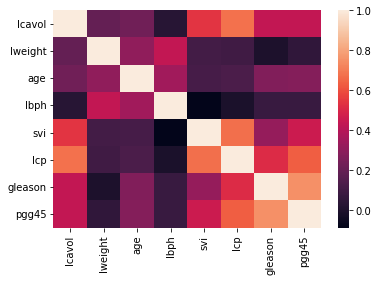

In [28]:
corr = get_dsg_mtx(lmod).corr()
sns.heatmap(corr)
corr

There is a clear problem with the lower right square. </br>
We might think about keeping only one from total 4 of those predictors. </br>
Which one? We certainly prefer significant over nonsignificant. 
Among the significant ones, a reasonable choice would be the one with the highest $\rho$ </br>
In our case only *svi* is significant. </br>
Interestingly, it is also the most correlated one among the rest:

In [29]:
prostate.corr()["lpsa"]

lcavol     0.734460
lweight    0.354122
age        0.169593
lbph       0.179810
svi        0.566218
lcp        0.548813
gleason    0.368987
pgg45      0.422316
lpsa       1.000000
Name: lpsa, dtype: float64

In [30]:
lmod_nonl = smf.ols(
    "lpsa ~ lcavol + lweight + age + lbph + svi",
    data=prostate
).fit()
lmod_nonl.sumary()

           coefs stderr tvalues pvalues
Intercept  0.951  0.832    1.14  0.2559
lcavol     0.566  0.075    7.58  0.0000
lweight    0.424  0.167    2.54  0.0128
age       -0.015  0.011   -1.38  0.1695
lbph       0.112  0.058    1.93  0.0572
svi        0.721  0.209    3.45  0.0009

n=97 p=6 Residual SD=0.707 R-squared=0.64


In [31]:
get_cond_nums(lmod_nonl)

array([752.19502374, 190.60575784, 119.72838879,  55.09410273,
        44.66999831,   1.        ])

In [32]:
1 / (1-get_partial_rsq(lmod_nonl))

Intercept    134.134225
lcavol         1.483085
svi            1.436938
lbph           1.361196
lweight        1.317926
age            1.230286
dtype: float64

In [33]:
lmod_nonl2 = smf.ols(
    "lpsa ~ lcavol + lweight + lbph + svi",
    data=prostate
).fit()
lmod_nonl2.sumary()

          coefs stderr tvalues pvalues
Intercept 0.146  0.597    0.24  0.8081
lcavol    0.550  0.074    7.42  0.0000
lweight   0.391  0.166    2.35  0.0207
lbph      0.090  0.056    1.60  0.1121
svi       0.712  0.210    3.39  0.0010

n=97 p=5 Residual SD=0.711 R-squared=0.64


In [34]:
get_cond_nums(lmod_nonl2)

array([35.10663574, 12.08070384,  3.7355786 ,  2.8373097 ,  1.        ])

In [35]:
1 / (1-get_partial_rsq(lmod_nonl2))

Intercept    68.530719
lcavol        1.447473
svi           1.435481
lweight       1.291345
lbph          1.261576
dtype: float64

## Model Selection

In [36]:
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept  0.669  1.296    0.52  0.6069
lcavol     0.587  0.088    6.68  0.0000
lweight    0.454  0.170    2.67  0.0090
age       -0.020  0.011   -1.76  0.0823
lbph       0.107  0.058    1.83  0.0704
svi        0.766  0.244    3.14  0.0023
lcp       -0.105  0.091   -1.16  0.2496
gleason    0.045  0.157    0.29  0.7750
pgg45      0.005  0.004    1.02  0.3089

n=97 p=9 Residual SD=0.708 R-squared=0.65


### Backward elimination
Note that it does not remove the intercept

In [102]:
y = lmod.model.endog
X1 = pd.DataFrame(lmod.model.exog, columns=lmod.params.index)

Xi = X1
lmodi = lmod
mpval = lmodi.pvalues.max()
be_imp = []

while mpval > 0.05:
    pred_to_remove = lmodi.pvalues.drop("Intercept").idxmax()
    be_imp.insert(0, pred_to_remove)
    print("\nRemove: ", pred_to_remove, "with pval:", mpval.round(2))
    Xi = Xi.drop(columns=pred_to_remove)
    lmodi = sm.OLS(y, Xi).fit()
    lmodi.sumary()
    mpval = lmodi.pvalues.drop("Intercept").max()
be_imp


Remove:  gleason with pval: 0.78
           coefs stderr tvalues pvalues
Intercept  0.954  0.829    1.15  0.2532
lcavol     0.592  0.086    6.88  0.0000
lweight    0.448  0.168    2.67  0.0090
age       -0.019  0.011   -1.75  0.0840
lbph       0.108  0.058    1.85  0.0672
svi        0.758  0.241    3.14  0.0023
lcp       -0.104  0.090   -1.15  0.2513
pgg45      0.005  0.003    1.55  0.1249

n=97 p=8 Residual SD=0.705 R-squared=0.65

Remove:  lcp with pval: 0.25
           coefs stderr tvalues pvalues
Intercept  0.980  0.831    1.18  0.2412
lcavol     0.546  0.076    7.14  0.0000
lweight    0.449  0.168    2.67  0.0089
age       -0.017  0.011   -1.59  0.1147
lbph       0.106  0.058    1.82  0.0725
svi        0.642  0.220    2.92  0.0044
pgg45      0.004  0.003    1.15  0.2533

n=97 p=7 Residual SD=0.706 R-squared=0.65

Remove:  pgg45 with pval: 0.25
           coefs stderr tvalues pvalues
Intercept  0.951  0.832    1.14  0.2559
lcavol     0.566  0.075    7.58  0.0000
lweight    0.424  

['lbph', 'age', 'pgg45', 'lcp', 'gleason']

Interestingly, the procedure picks the same predictors as the ones significant in the full model. </br>
This is not always the case. It might well happend that as one remove insignificant variables the other ones become significant.

#### Recursive Feature Elimination (RFE)

In [70]:
from sklearn.preprocessing import scale
scaled_prostate = pd.DataFrame(scale(prostate), columns=prostate.columns)
X=scaled_prostate.drop(columns="lpsa")
y=scaled_prostate.loc[:, "lpsa"]

from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X, y)
reg.coef_, reg.intercept_

(array([ 0.59937738,  0.19552622, -0.12665462,  0.13454979,  0.27477892,
        -0.12776184,  0.02824004,  0.11056623]),
 9.129315014908017e-18)

Note that since the data is scaled, 
$$\begin{cases}
\hat\beta_0=0,\\ 
|\hat\beta_i| \in [0;1]
\end{cases}$$
Thus, coefficients can be interpreted as the relative contributions of the predictors to explaining the response. </br>
This suggests the RFE method: iteratively eliminate the "less important" ones.


In [91]:
from sklearn.feature_selection import RFE
selector = RFE(reg, n_features_to_select=1)
selector = selector.fit(X, y)
selector.ranking_

array([1, 3, 7, 4, 2, 5, 8, 6])

This says that the first column was found to be the most relevant one, the 5th column was second best and so on. </br>
We can get the column indices listed according to their relative importance as follows:

In [84]:
np.argsort(selector.ranking_)

array([0, 4, 1, 3, 5, 7, 2, 6])

In [98]:
rfe_imp = list(X.columns[np.argsort(selector.ranking_)])
rfe_imp

['lcavol', 'svi', 'lweight', 'lbph', 'lcp', 'pgg45', 'age', 'gleason']

We are not surprised to see `gleason` taking the last place, since, in the first iteration:

In [87]:
X.columns[np.abs(reg.coef_).argmin()]

'gleason'

If we were to change `n_features` to some other value, then the algorithm would simply stop when the specified number of features is obtained. Comparing this to the previous result, this means that the rankings shift:

In [93]:
from sklearn.feature_selection import RFE
selector = RFE(reg, n_features_to_select=2)
selector = selector.fit(X, y)
selector.ranking_

array([1, 2, 6, 3, 1, 4, 7, 5])

The model has ranked `lcavol`, `svi` and `lweight` as the most important variables. </br>
These are the same ones as turned out to be included in the model after Backward elimination. </br>
This would not generally be the case: hypothesis-test (looking at p-values at different times) procedures. </br>
Even in this case we see that the importance rankings for two procedures differ:

In [103]:
print(rfe_imp[3:])
be_imp

['lbph', 'lcp', 'pgg45', 'age', 'gleason']


['lbph', 'age', 'pgg45', 'lcp', 'gleason']

Let's see how good the resulting model compares to the best one according to AIC.

In [133]:
import itertools
pcols = list(X.columns)

rss = np.empty(len(pcols) + 1)
# rss for 0-predictor model
# only one parameter \beta_0
# which is estimated by y.bar
rss[0] = np. sum(
    (prostate["lpsa"] - np.mean(prostate["lpsa"]))**2
)
selvar = ['None']

for k in range(1, len(pcols)+1):
    RSS = {}
    for variables in itertools.combinations(pcols, k):
        predictors = prostate.loc[:, list(variables)]
        predictors['Intercept'] = 1
        res = sm.OLS(prostate["lpsa"], predictors).fit()
        RSS[variables] = res.ssr
    rss[k] = min(RSS.values())
    selvar.append(min(RSS, key=RSS.get))
    
min_rss_models = list(zip(selvar, rss.round(3)))
min_rss_models

[('None', 127.918),
 (('lcavol',), 58.915),
 (('lcavol', 'lweight'), 52.966),
 (('lcavol', 'lweight', 'svi'), 47.785),
 (('lcavol', 'lweight', 'lbph', 'svi'), 46.485),
 (('lcavol', 'lweight', 'age', 'lbph', 'svi'), 45.526),
 (('lcavol', 'lweight', 'age', 'lbph', 'svi', 'pgg45'), 44.867),
 (('lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45'), 44.204),
 (('lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45'),
  44.163)]

Text(0, 0.5, 'min RSS')

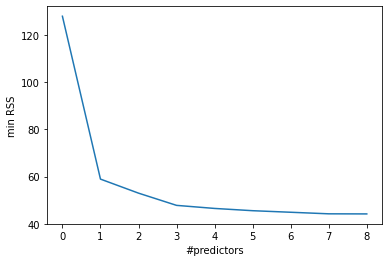

In [110]:
f, ax = plt.subplots()
ax.plot(range(0, len(pcols)+1), rss)
ax.set_xlabel("#predictors")
ax.set_ylabel("min RSS")

There are two commonly used measures of performance for comparing models (and therefore selecting one).
$$  AIC = -2L(\hat\theta) + 2p$$
which for linear regression under $\epsilon \sim \mathcal{N_n}(\mu,\,\sigma^{2}I_n)$ becomes:
$$AIC = nlog(\frac{RSS}{n}) +2p$$
$$R_{adj}^2=1 - \frac{(1-R^2)(n-1)}{n-p-1}$$

In [139]:
n = X.shape[0]
aic = n * np.log(rss/n) + 2*np.arange(1, len(rss)+1)
print(aic, aic.argmin())

rsq = 1 - rss/rss[0]
rsq_adj = 1 - (1-rsq)*(n-1)/(n-np.arange(rss.shape[0]))
rsq_adj, rsq_adj.argmax()

[ 28.83749469 -44.36607865 -52.69042533 -60.67620569 -61.35179309
 -61.37439196 -60.78867481 -60.23129517 -58.32184232] 5


(array([0.01030928, 0.53943191, 0.58157593, 0.61849217, 0.62488101,
        0.62862859, 0.62998206, 0.63139377, 0.62759991]),
 7)

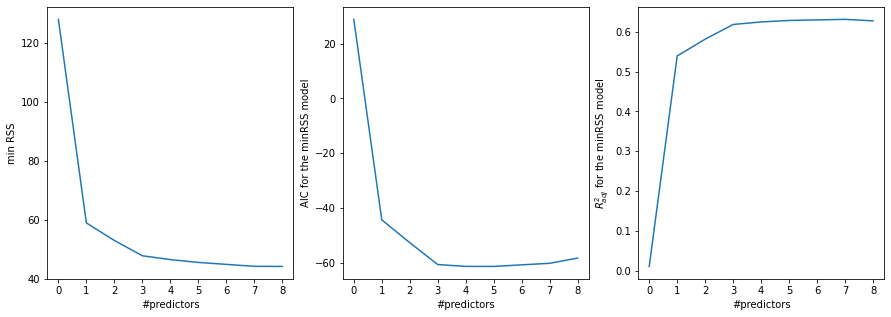

In [143]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(range(0, len(rss)), rss)
ax1.set_xlabel("#predictors")
ax1.set_ylabel("min RSS")

ax2.plot(range(0, len(rss)), aic)
ax2.set_xlabel("#predictors")
ax2.set_ylabel("AIC for the minRSS model")


ax3.plot(range(0, len(rss)), rsq_adj)
ax3.set_xlabel("#predictors")
ax3.set_ylabel("$R^2_{adj}$ for the minRSS model")

for ax in (ax1, ax2, ax3):
    ax.set_xticks(range(0, len(rss)))

Not surprisingly, the intercept for the RSS always decreases. </br>
AIC, though being minimized at 5 predictors, has a similar value for 3 predictor model, which is:

In [134]:
min_rss_models[3]

(('lcavol', 'lweight', 'svi'), 47.785)

As we see, the model which is obtained and suggested by BE and RFE, respectively, has a near-optimal values in terms of $AIC$, $R^2_{adj}$

### Sample spliting
is an alternative approach for choosing between several existing models.</br>
It might be complicated by the relatively small sample size